## Package Import

In [1]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.0/981.0 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.6 MB/s eta 0:00:00


In [50]:
from darts.models import Prophet, LinearRegressionModel, AutoARIMA, Theta, ExponentialSmoothing
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts import TimeSeries
from darts.timeseries import concatenate
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape, rmse, mase, r2_score, mae
from darts import concatenate
from darts.dataprocessing.transformers import MinTReconciliator, BottomUpReconciliator, TopDownReconciliator
import pandas as pd
from pandas import Timestamp
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


# Model

### Data Import + Utils

In [54]:

# Load the data from an Excel file
file_path = 'SampleHierForecastingBASF_share.xlsx'  # Replace with your actual file path
df = pd.read_excel(file_path)

# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%y')

# Ensure the dataframe is sorted by date
df = df.sort_values(by='Date')

# Split the data into Train, Test, and Validation datasets
train_data = df[(df['Date'] >= '2008-01-01') & (df['Date'] <= '2021-12-31')]
test_data = df[(df['Date'] >= '2022-01-01') & (df['Date'] <= '2022-12-31')]
validation_data = df[(df['Date'] >= '2023-01-01') & (df['Date'] <= '2023-12-31')]

# Display the sizes of the splits
print(f"Training Data Size: {train_data.shape[0]} rows")
print(f"Testing Data Size: {test_data.shape[0]} rows")
print(f"Validation Data Size: {validation_data.shape[0]} rows")

# Verify the splits (optional)
print("Training Data Sample:")
print(train_data.head())

Training Data Size: 168 rows
Testing Data Size: 12 rows
Validation Data Size: 12 rows
Training Data Sample:
        Date      NetSales  VariableCosts  ContributionMargin1      FixCosts  \
0 2008-01-01  46395.562988   11530.938420         34864.624569  28085.056839   
1 2008-02-01  71258.917420   23005.990813         48252.926607  25574.419442   
2 2008-03-01  82672.156481   33251.338936         49420.817545  23989.711891   
3 2008-04-01  91239.441986   33569.084866         57670.357120  26096.657423   
4 2008-05-01  76852.388916   31133.385550         45719.003366  23010.859671   

           EBIT  DepreciationAmortization        EBITDA  
0   6779.567730               3913.291983  10692.859713  
1  22678.507166               2656.703148  25335.210314  
2  25431.105654               3308.918478  28740.024133  
3  31573.699697               4013.632803  35587.332501  
4  22708.143695               3241.601219  25949.744914  


In [55]:
def get_metrics(pred,val, name ):
  #book (forecasting: principles and practices) suggests rmse and mase as best measures
  print(f"MAE for {name}: {mae(val,pred):.2f}")
  #print(f"MASE for {name}: {mase(val,pred):.2f}")
  print(f"MAPE for {name}: {mape(val,pred):.2f}")
  print(f"RMSE for {name}: {rmse(val, pred):.2f}")


### Prediction with Regression Model

#### Implementing Hierarchy

In [56]:
df['-VariableCosts'] = -df['VariableCosts']
df['-DepreciationAmortization']=-df['DepreciationAmortization']
df['-FixCosts'] = -df['FixCosts']

In [57]:
topdown = ["EBITDA", "-DepreciationAmortization"]
bottomup2 = ["ContributionMargin1", "-FixCosts"]
bottomup1 = ["NetSales", "-VariableCosts"]

In [58]:
hierarchy = dict()

# Fill in topdown variables
for var in topdown:
    hierarchy[var] = ["EBIT"]

# Fill in bottomup2 variables
for var in bottomup2:
    hierarchy[var] = ["EBIT"]

# Fill in bottomup1 variables
for var in bottomup1:
    hierarchy[var] = ["ContributionMargin1"]

In [59]:
hierarchy = {
    'EBITDA': ['EBIT'],
    '-DepreciationAmortization': ['EBIT'],
    'ContributionMargin1': ['EBIT'],
    '-FixCosts': ['EBIT'],
    'NetSales': ['ContributionMargin1'],
    '-VariableCosts': ['ContributionMargin1']
}

series = TimeSeries.from_dataframe(df, time_col="Date", value_cols=[
    "EBIT","EBITDA", "-DepreciationAmortization", "ContributionMargin1", "-FixCosts", "NetSales", "-VariableCosts"
])
series = series.with_hierarchy(hierarchy)

#### Adding Covariates

In [60]:
#yearly global inflation data from world bank, extra explanatory variable for model
inflation = pd.read_excel('globalinflation.xlsx')
inflation = inflation.T
inflation.index = pd.to_datetime(inflation.index, format='%Y')
# Create a complete date range from the first month of the first year to the last month of the last year
start_date = inflation.index.min()
end_date = inflation.index.max() + pd.DateOffset(months=11)  # Go to the last month of the final year

# Generate a date range for all months in the period
date_range = pd.date_range(start=start_date, end=end_date, freq='MS')

# Reindex the DataFrame to this new monthly range (this adds missing months)
inflation = inflation.reindex(date_range)
#inflation = inflation.ffill()
inflation = inflation.interpolate(method="linear")
inflation = inflation.reset_index()
inflation.columns = ["date","inflation_rate"]
#now inf_series is the estimated global monthly inflation rates
# this should be past covariates i think, oops
future_cov = TimeSeries.from_dataframe(inflation, time_col="date", value_cols="inflation_rate")

In [61]:
# future_cov are additional explanatory features extrapolated from datetime, recommended for profit
future_cov = datetime_attribute_timeseries(series, "month", cyclic=True)
future_cov = future_cov.stack(datetime_attribute_timeseries(series, "year", cyclic=False))
future_cov = future_cov.stack(datetime_attribute_timeseries(series, "quarter", cyclic=True))
#TODO: try adding 1,3, 6 month lags
#future_cov = future_cov.stack(lagged)
future_cov = future_cov.stack(inf_series)

NameError: name 'inf_series' is not defined

#### Model Training (2022 as validation year)

In [62]:
train, val = series[:-24], series[-24:-12]
#with covariates
model = LinearRegressionModel(lags=12, lags_future_covariates=[12,12,12,12])
model.fit(train, future_covariates=future_cov)
pred = model.predict(n=len(val), future_covariates=future_cov)

In [63]:
train, val = series[:-24], series[-24:-12]
#without covariates, don't run both this cell and the previous!!!
model = LinearRegressionModel(lags=12)
#add lags and lags_covariates?
model.fit(train)
pred = model.predict(n=len(val))

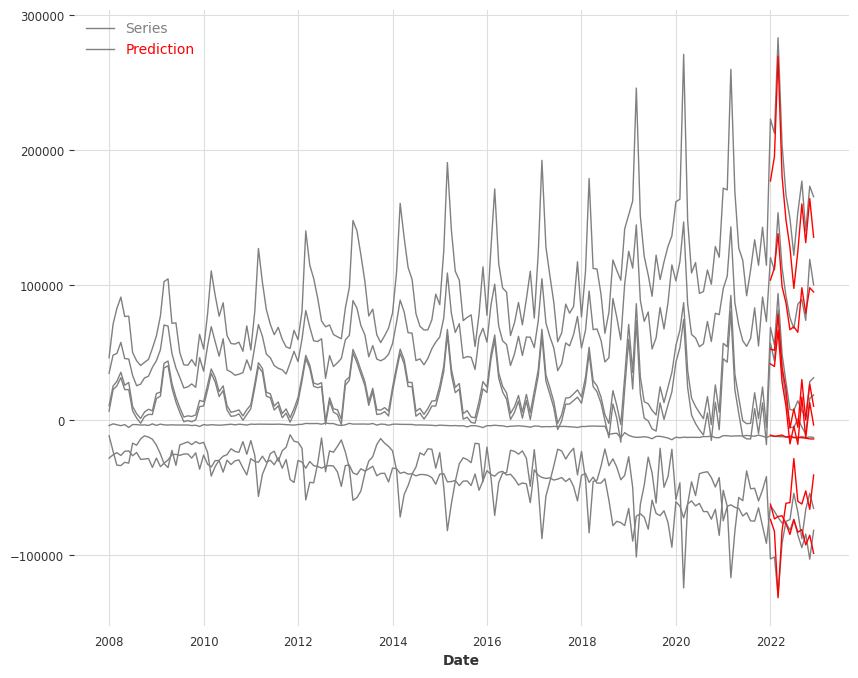

In [64]:
#how did we do? plot to see
components_to_show = ["EBIT","EBITDA", "-DepreciationAmortization", "ContributionMargin1", "-FixCosts", "NetSales", "-VariableCosts"]
plt.figure(figsize=(10, 8))
#filter so we only show dates we actually calculated predictions for
filtered_series = series.drop_after(Timestamp('2022-12-31'))
filtered_series[components_to_show].plot(lw=1, color='gray', label='Series')
pred[components_to_show].plot(lw=1, color='red', label='Prediction')

plt.legend(["Series", "Prediction"], loc="upper left", labelcolor=["gray","red"])
plt.show()

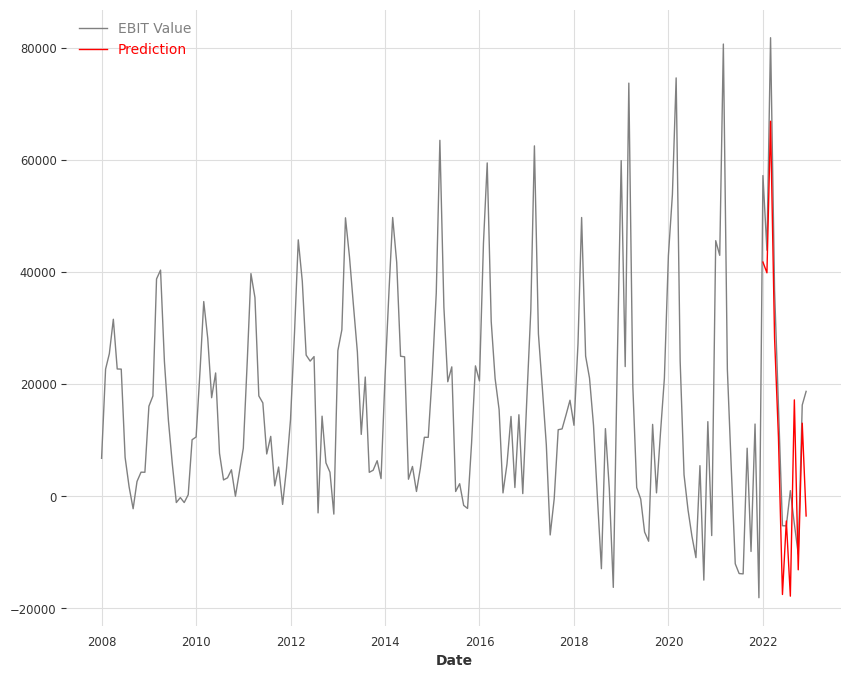

In [65]:

# a lot going on there, let's just look at the target variable
plt.figure(figsize=(10, 8))
filtered_series['EBIT'].plot(lw=1, color='gray', label='EBIT Value')
pred['EBIT'].plot(lw=1, color='red', label='Prediction')

plt.legend(["EBIT Value", "Prediction"], loc="upper left", labelcolor=["gray","red"])
plt.show()

In [66]:
get_metrics(pred, val, "LR, no backtesting")

MAE for LR, no backtesting: 11029.05
MAPE for LR, no backtesting: 52.81
RMSE for LR, no backtesting: 12952.69


#### Forecast Window Test

In [67]:
#]what is the best forecasting model for regression model?
for i in [1,3,6,12]:
  backtest_results = model.historical_forecasts(
      series[:-12],
      #future_covariates=future_cov,
      start=0.6,  # Start backtesting after 60% of the dataset
      forecast_horizon=i,
      stride=1,  # Move forward one step at a time
      retrain=True,  # Retrain after each forecast
  )
  get_metrics(backtest_results, val, "LR with Backtest, forecast horizon "+str(i))
  print()


MAE for LR with Backtest, forecast horizon 1: 9872.47
MAPE for LR with Backtest, forecast horizon 1: 45.39
RMSE for LR with Backtest, forecast horizon 1: 11778.32



MAE for LR with Backtest, forecast horizon 3: 9123.38
MAPE for LR with Backtest, forecast horizon 3: 49.40
RMSE for LR with Backtest, forecast horizon 3: 10933.19



MAE for LR with Backtest, forecast horizon 6: 10843.11
MAPE for LR with Backtest, forecast horizon 6: 61.07
RMSE for LR with Backtest, forecast horizon 6: 12646.27

MAE for LR with Backtest, forecast horizon 12: 11848.74
MAPE for LR with Backtest, forecast horizon 12: 53.95
RMSE for LR with Backtest, forecast horizon 12: 13904.54



In [68]:
#best forecast horizon for ExponentialSMmoothing and Prophet
for i in [6,12,24,36]:
  backtest_results = ExponentialSmoothing().historical_forecasts(
      series['EBIT'][:-12],
      #future_covariates=future_cov,
      start=0.6,  # Start backtesting after 60% of the dataset
      forecast_horizon=i,
      stride=1,  # Move forward one step at a time
      retrain=True,  # Retrain after each forecast
  )
  get_metrics(backtest_results, val['EBIT'], "Exponential Smoothing, forecast horizon "+str(i))
  print()

#for i in [1,3,6,12]:
 # backtest_results = Prophet().historical_forecasts(
  #    series['EBIT'][:-12],
      #future_covariates=future_cov,
   #   start=0.6,  # Start backtesting after 60% of the dataset
    #  forecast_horizon=i,
     # stride=1,  # Move forward one step at a time
      #retrain=True,  # Retrain after each forecast
  #)
  #get_metrics(backtest_results, val['EBIT'], "Prophet, forecast horizon "+str(i))
  #print()


MAE for Exponential Smoothing, forecast horizon 6: 10340.07
MAPE for Exponential Smoothing, forecast horizon 6: 185.03
RMSE for Exponential Smoothing, forecast horizon 6: 12438.13

MAE for Exponential Smoothing, forecast horizon 12: 9104.62
MAPE for Exponential Smoothing, forecast horizon 12: 156.10
RMSE for Exponential Smoothing, forecast horizon 12: 10503.56

MAE for Exponential Smoothing, forecast horizon 24: 10329.00
MAPE for Exponential Smoothing, forecast horizon 24: 120.36
RMSE for Exponential Smoothing, forecast horizon 24: 12026.11

MAE for Exponential Smoothing, forecast horizon 36: 11964.15
MAPE for Exponential Smoothing, forecast horizon 36: 147.62
RMSE for Exponential Smoothing, forecast horizon 36: 15405.46



In [69]:
backtest_results = model.historical_forecasts(
      series[:-12],
      #future_covariates=future_cov,
      start=0.6,  # Start backtesting after 60% of the dataset
      forecast_horizon=i,
      stride=1,  # Move forward one step at a time
      retrain=True,  # Retrain after each forecast
  )
get_metrics(backtest_results, val, "LR with Backtesting")


MAE for LR with Backtesting: 382000.42
MAPE for LR with Backtesting: 880.24
RMSE for LR with Backtesting: 658686.26


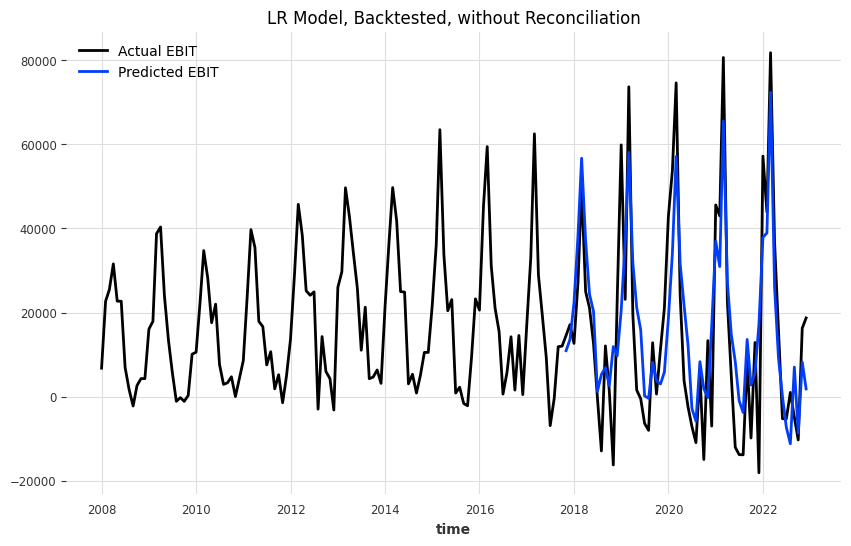

In [94]:
plt.figure(figsize=(10, 6))
filtered_series["EBIT"].plot(label="Actual EBIT")
backtest_results["EBIT"].plot(label="Predicted EBIT")
plt.legend()
plt.title("LR Model, Backtested, without Reconciliation")
plt.show()

In [71]:
get_metrics(backtest_results, val, "LR with Backtest")
print()


MAE for LR with Backtest: 382000.42
MAPE for LR with Backtest: 880.24
RMSE for LR with Backtest: 658686.26



### Reconciliation

In [72]:
reconciliator0 = MinTReconciliator(method="wls_val")
reconciliator0.fit(train)
reconciled0_preds = reconciliator0.transform(pred)
get_metrics(reconciled0_preds, val, "MinT, LR")
#plot_forecast_sums(reconciled0_preds)
print()
reconciled0_back = reconciliator0.transform(backtest_results)
get_metrics(reconciled0_back, val, "MinT, LR w/ Backtesting")
#plot_forecast_sums(reconciled0_preds)

MAE for MinT, LR: 37415.45
MAPE for MinT, LR: 114.37
RMSE for MinT, LR: 47904.00

MAE for MinT, LR w/ Backtesting: 639662.50
MAPE for MinT, LR w/ Backtesting: 1503.85
RMSE for MinT, LR w/ Backtesting: 992742.91


In [87]:
reconciliator1 = BottomUpReconciliator()
reconciled1_preds = reconciliator1.transform(pred)
get_metrics(reconciled1_preds, val, "Bottom Up, LR")
#plot_forecast_sums(reconciled1_preds)
print()
reconciled_backtested = reconciliator1.transform(backtest_results)
get_metrics(reconciled_backtested, val, "Bottom Up Reconciliation, LR w/ Backtest")

MAE for Bottom Up, LR: 13036.60
MAPE for Bottom Up, LR: 86.66
RMSE for Bottom Up, LR: 15169.75

MAE for Bottom Up Reconciliation, LR w/ Backtest: 16363.04
MAPE for Bottom Up Reconciliation, LR w/ Backtest: 71.02
RMSE for Bottom Up Reconciliation, LR w/ Backtest: 19117.08


In [74]:
reconciliator2 = TopDownReconciliator()
reconciliator2.fit(train)
reconciled2_preds = reconciliator2.transform(pred)
get_metrics(reconciled2_preds, val, "Top Down, LR")
#plot_forecast_sums(reconciled1_preds)
print()
topdown_back = reconciliator2.transform(backtest_results)
get_metrics(topdown_back, val, "Top Down Reconciliation, LR w/ Backtest")

MAE for Top Down, LR: 56123.98
MAPE for Top Down, LR: 153.48
RMSE for Top Down, LR: 65394.55

MAE for Top Down Reconciliation, LR w/ Backtest: 549765.86
MAPE for Top Down Reconciliation, LR w/ Backtest: 1284.09
RMSE for Top Down Reconciliation, LR w/ Backtest: 711155.18


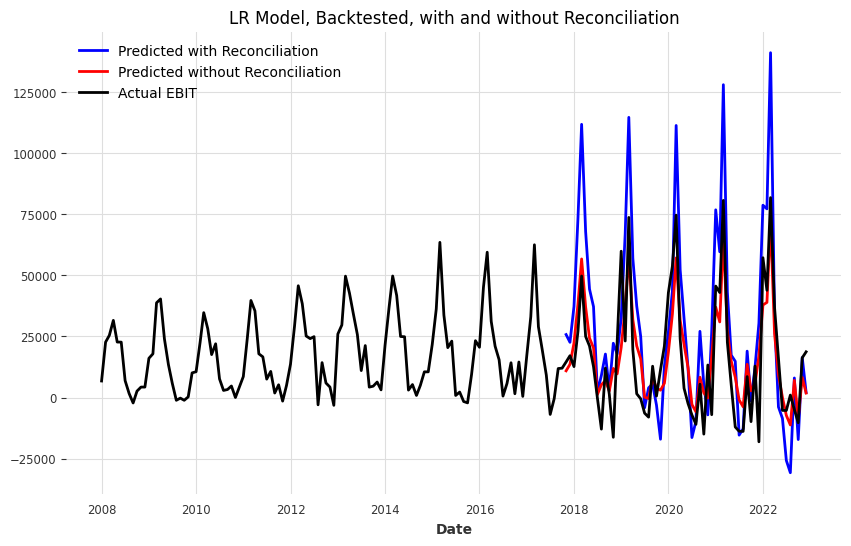

In [93]:
plt.figure(figsize=(10, 6))
reconciled_backtested["EBIT"].plot(label="Predicted with Reconciliation", color="blue")
backtest_results["EBIT"].plot(label="Predicted without Reconciliation", color="red")
filtered_series["EBIT"].plot(label="Actual EBIT", color="black")

plt.legend()
plt.title("LR Model, Backtested, with and without Reconciliation")
plt.show()

In [76]:
#this performs worst, which makes theoretical sense based on our hierarchy
reconciliator2 = TopDownReconciliator()
reconciliator2.fit(train)
reconciled2_preds = reconciliator2.transform(pred)
get_metrics(reconciled2_preds, val, "Top Down")
#plot_forecast_sums(reconciled2_preds)

MAE for Top Down: 56123.98
MAPE for Top Down: 153.48
RMSE for Top Down: 65394.55


### Model Training (Exponential Smoothing with Backtesting)

In [81]:
backtest_results_dict = {}  # Dictionary to store individual component backtests

# what if we do exponential smoothing on everything?
for key in forecasts_dict.keys():
    model = ExponentialSmoothing()
    model.fit(series_dict[key][:-12])  # Fit to training data
    backtest_results_dict[key] = model.historical_forecasts(
        series_dict[key][:-12],
        start=0.6,
        forecast_horizon=12,
        stride=1,
        retrain=True
    )
# Combine the individual backtest results into a single TimeSeries
backtest_results = concatenate(list(backtest_results_dict.values()), axis=1)

# Add the hierarchy to backtest_results (if you need it for reconciliation)
backtest_results = backtest_results.with_hierarchy(hierarchy)

# Now apply your reconciliation method (like BottomUpReconciliator)
reconciled_backtest_results = reconciliator1.transform(backtest_results)

In [83]:
get_metrics(backtest_results,val, "Exponential Smoothing with Backtest")


MAE for Exponential Smoothing with Backtest: 13984.51
MAPE for Exponential Smoothing with Backtest: 40.65
RMSE for Exponential Smoothing with Backtest: 16207.66


In [82]:
#again, reconciliation lowers performance(!)
get_metrics(reconciled_backtest_results, val, "Exponential Smoothing with Backtest, Reconciled")

MAE for Exponential Smoothing with Backtest, Reconciled: 16363.04
MAPE for Exponential Smoothing with Backtest, Reconciled: 71.02
RMSE for Exponential Smoothing with Backtest, Reconciled: 19117.08


### Model Training (Separate Series)

In [80]:
train, val = series[:-24], series[-24:-12]


series_dict = {
    "EBIT": TimeSeries.from_dataframe(df, time_col="Date", value_cols=["EBIT"]),
    "EBITDA": TimeSeries.from_dataframe(df, time_col="Date", value_cols=["EBITDA"]),
    "-DepreciationAmortization":  TimeSeries.from_dataframe(df, time_col="Date", value_cols=["-DepreciationAmortization"]),
    "ContributionMargin1" : TimeSeries.from_dataframe(df, time_col="Date", value_cols=["ContributionMargin1"]),
    "-FixCosts" : TimeSeries.from_dataframe(df, time_col="Date", value_cols=["-FixCosts"]),
    "NetSales": TimeSeries.from_dataframe(df, time_col="Date", value_cols=["NetSales"]),
    "-VariableCosts" : TimeSeries.from_dataframe(df, time_col="Date", value_cols=["-VariableCosts"]),
}


# Train models separately for each series
forecasts_dict = {}
for key in series_dict.keys():
    if key =="EBIT" or key == "EBITDA":
      model = AutoARIMA(lags=12)
    else:
      model = LinearRegressionModel(lags=12)
    model.fit(series_dict[key][:-24])
    forecasts_dict[key] = model.predict(n=len(val))

forecasts = concatenate(list(forecasts_dict.values()), axis=1)

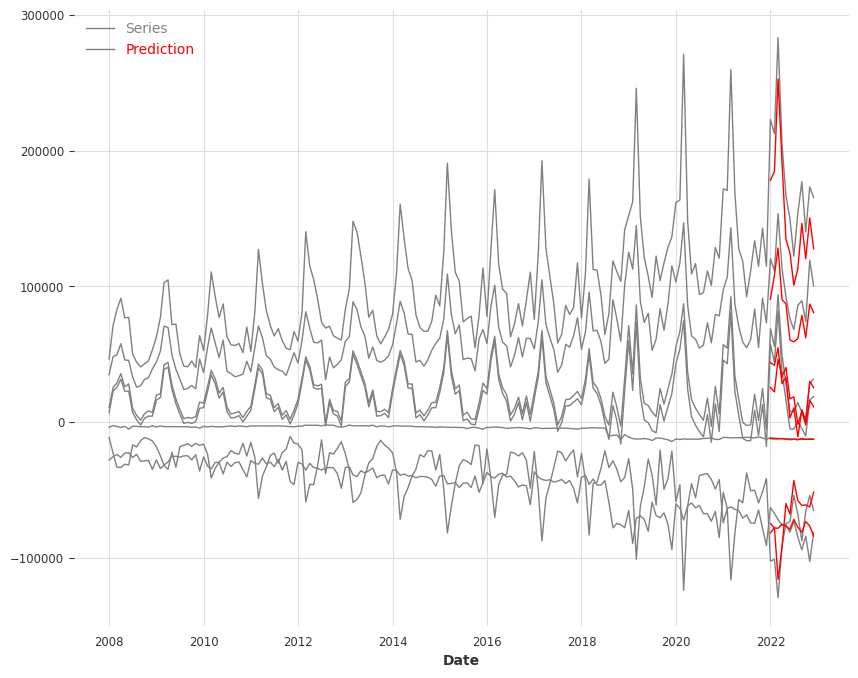

In [147]:
#how did we do? plot to see
components_to_show = ["EBIT","EBITDA", "-DepreciationAmortization", "ContributionMargin1", "-FixCosts", "NetSales", "-VariableCosts"]
plt.figure(figsize=(10, 8))
#filter so we only show dates we actually calculated predictions for
filtered_series = series.drop_after(Timestamp('2022-12-31'))
filtered_series[components_to_show].plot(lw=1, color='gray', label='Series')
for component in components_to_show:
    if component in forecasts_dict:  # Check if component exists in forecasts_dict
        forecasts_dict[component].plot(lw=1, color='red', label='Prediction')
plt.legend(["Series", "Prediction"], loc="upper left", labelcolor=["gray","red"])
plt.show()

In [148]:
forecasts = forecasts.with_hierarchy(hierarchy)

In [154]:
reconciled1_forecasts = reconciliator1.transform(forecasts)
get_metrics(reconciled1_forecasts, val, "Bottom Up, Forecasts Predicted Separately")


MAE for Bottom Up, Forecasts Predicted Separately: 13499.52
MAPE for Bottom Up, Forecasts Predicted Separately: 86.03
RMSE for Bottom Up, Forecasts Predicted Separately: 15961.36
R-squared for Bottom Up, Forecasts Predicted Separately: 0.37


#### Backtesting

In [53]:
#now the version using separately trained time series AND backtesting
#todo: compare models for each covariate to find the best one


# Assuming forecasts_dict holds your individual forecasts (key: component, value: TimeSeries)
backtest_results_dict = {}  # Dictionary to store individual component backtests

# Loop 1: Backtesting with Exponential Smoorhing for EBIT and EBITDA
for key in ["EBIT", "EBITDA"]:
    model = AutoARIMA(lags=12)  # Assuming AutoARIMA for these components
    model.fit(series_dict[key][:-12])  # Fit to training data
    backtest_results_dict[key] = model.historical_forecasts(
        series_dict[key][:-12],
        start=0.6,
        forecast_horizon=6,
        stride=1,
        retrain=True
    )

# Loop 2: Backtesting with Linear Regression for other series
for key in forecasts_dict.keys():
    if key not in ["EBIT", "EBITDA"]:  # Exclude EBIT and EBITDA
        model = LinearRegressionModel(lags=3)  # Assuming Linear Regression
        model.fit(series_dict[key][:-12])  # Fit to training data
        backtest_results_dict[key] = model.historical_forecasts(
            series_dict[key][:-12],
            start=0.6,
            forecast_horizon=3,
            stride=1,
            retrain=True
        )
# Combine the individual backtest results into a single TimeSeries
backtest_results = concatenate(list(backtest_results_dict.values()), axis=1)

# Add the hierarchy to backtest_results (if you need it for reconciliation)
backtest_results = backtest_results.with_hierarchy(hierarchy)

# Now apply your reconciliation method (like BottomUpReconciliator)
reconciled_backtest_results = reconciliator1.transform(backtest_results)


NameError: name 'series_dict' is not defined

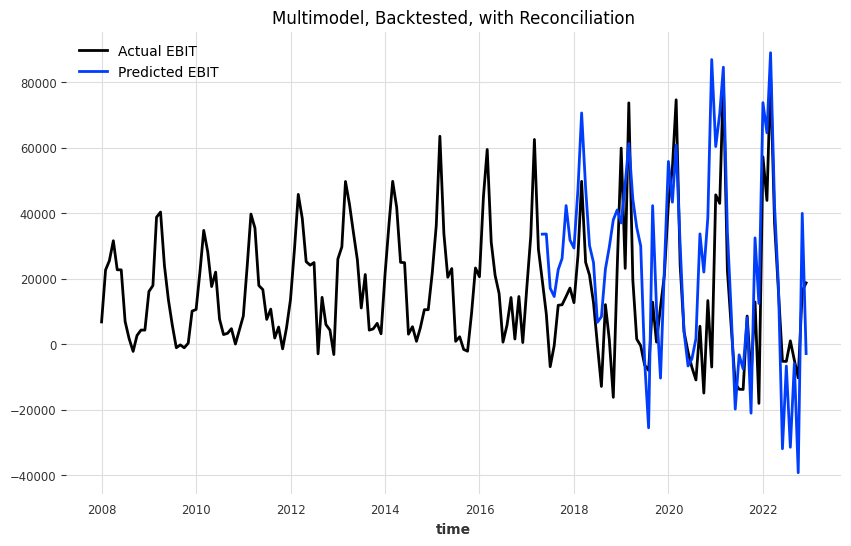

In [179]:
plt.figure(figsize=(10, 6))
filtered_series["EBIT"].plot(label="Actual EBIT")
reconciled_backtest_results_multimodel["EBIT"].plot(label="Predicted EBIT")
plt.legend()
plt.title("Multimodel, Backtested, with Reconciliation")
plt.show()


In [180]:
get_metrics(reconciled_backtest_results, val, "Multi Model with Backtest, Reconciled")
reconciled_backtest_results_multimodel = reconciled_backtest_results

MAE for Multi Model with Backtest, Reconciled: 13623.25
MAPE for Multi Model with Backtest, Reconciled: 74.31
RMSE for Multi Model with Backtest, Reconciled: 16238.96
R-squared for Multi Model with Backtest, Reconciled: 0.19
